In [1]:
import pandas as pd
import numpy as np
import os
import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#make simple linear regression and kernel ridge regression to predict the imbalance price for DK2
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import permutation_importance


from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
full_data_set = pd.read_csv('../data/processed/data.csv', index_col=0)

#all columns except of date columns
selected_columns = full_data_set.columns.difference(['date', 'datetime', 'year', 'month', 'day', 'hour'])
selected_columns
columns_ending_with_RE = [col for col in selected_columns if col.endswith('_RE')]
columns_with_zeta = [col for col in selected_columns if 'zeta' in col]
columns_ending_with_FC_error = [col for col in selected_columns if col.endswith('_FC_error')]

Index(['DK1_Accepted_Down_Volume_(MW)', 'DK1_Accepted_Up_Volume_(MW)',
       'DK2_Accepted_Down_Volume_(MW)', 'DK2_Accepted_Up_Volume_(MW)',
       'Solar_FC', 'Solar_FC_error_hourly_rollavg', 'Wind_offshore_FC',
       'Wind_offshore_FC_error_hourly_rollavg', 'Wind_onshore_FC',
       'Wind_onshore_FC_error_hourly_rollavg',
       'abs_diff_markets_RE_hourly_rollavg', 'diff_markets_RE_hourly_rollavg',
       'energy_FC', 'lambda_DA_FC', 'lambda_DA_FC_normalized',
       'lambda_DA_RE_hourly_rollavg', 'lambda_IM_hourly_rollavg', 'load_FC',
       'load_FC_error_hourly_rollavg', 'missing_capacity_RE_hourly_rollavg'],
      dtype='object')


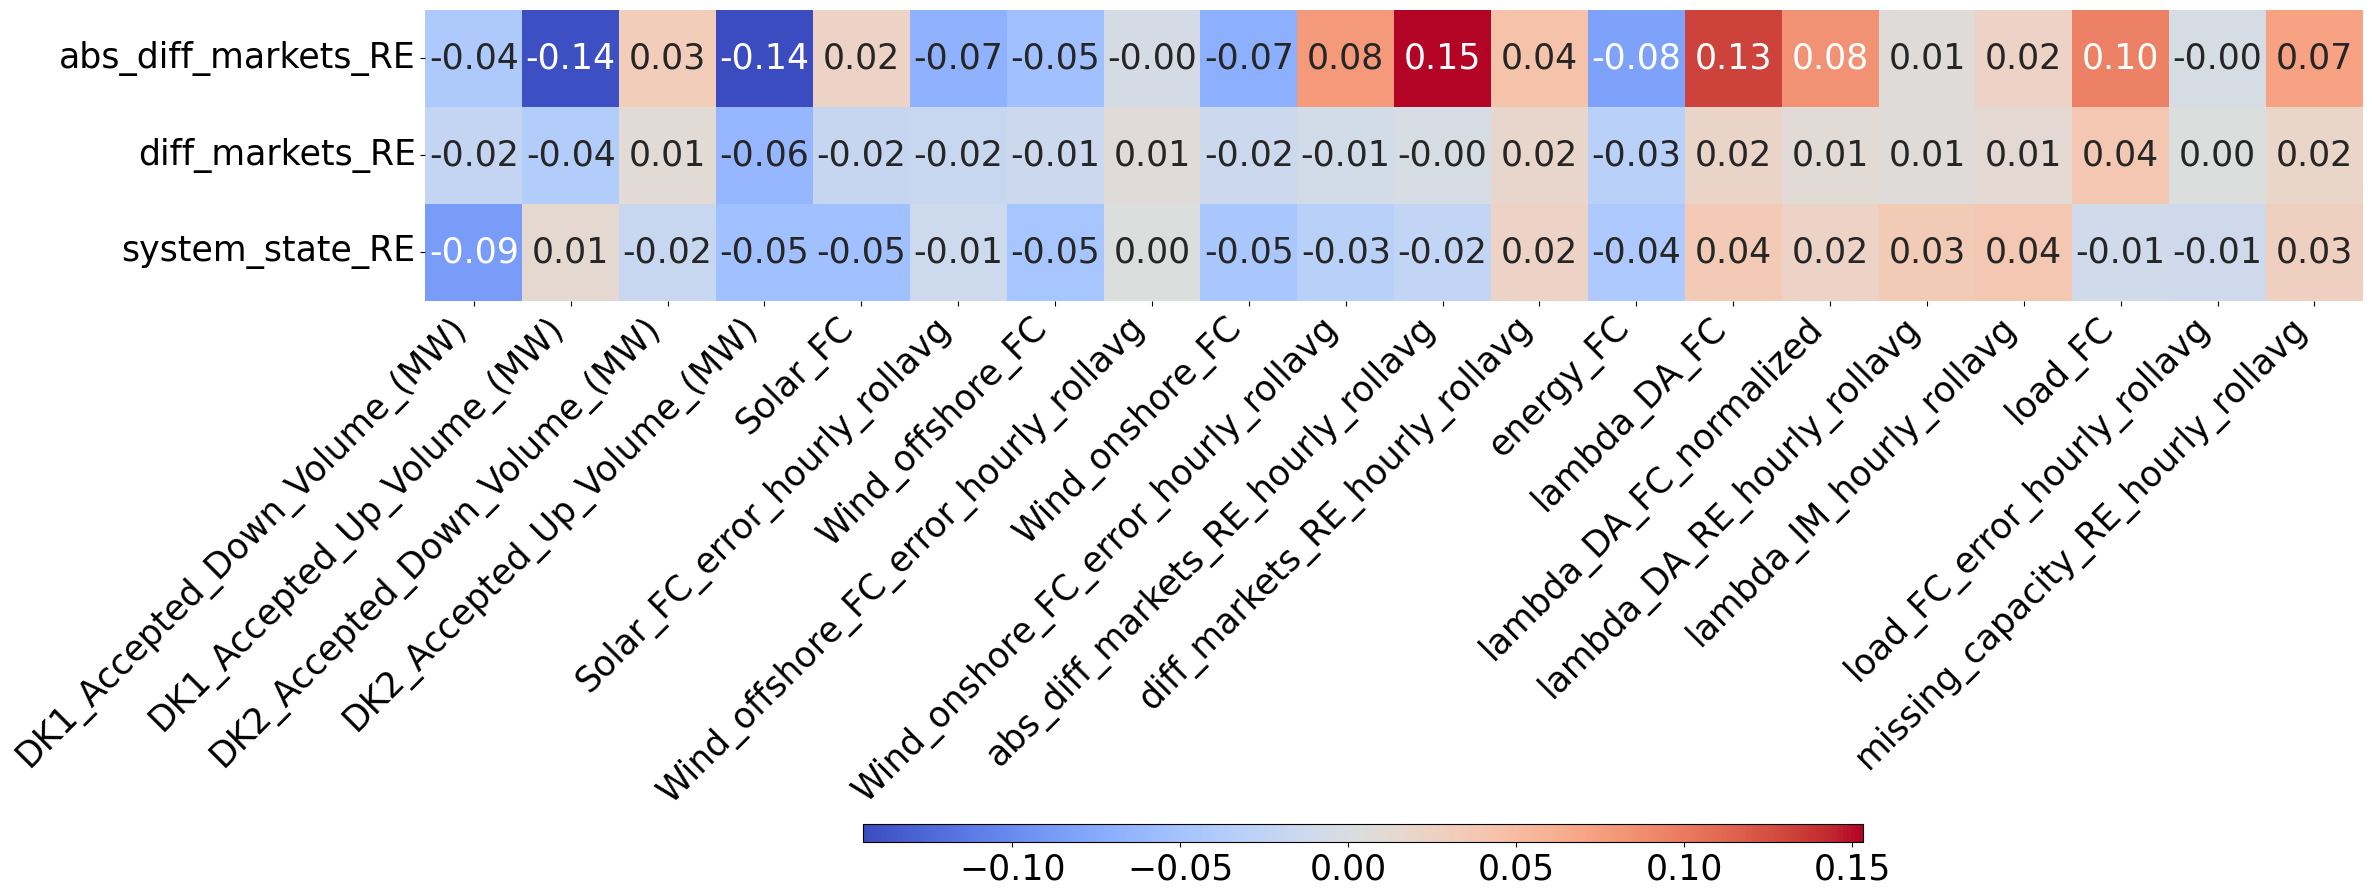

In [19]:
# Make a correlation matrix
corr = full_data_set[selected_columns].corr()

rows_of_interest = [
    "abs_diff_markets_RE",
    "diff_markets_RE",
    "system_state_RE"
]

filtered_corr = corr.loc[rows_of_interest]

columns_to_drop = [
    "DK1_Imbalance_Price_(EUR)",
    "abs_diff_markets_RE",
    "diff_markets_RE",
    "lambda_IM",
    "system_state_RE"
]

# Drop unwanted columns
filtered_corr = filtered_corr.drop(columns=columns_to_drop, errors="ignore")
filtered_corr = filtered_corr.drop(columns=columns_ending_with_RE, errors="ignore")
filtered_corr = filtered_corr.drop(columns=columns_with_zeta, errors="ignore")
filtered_corr = filtered_corr.drop(columns=columns_ending_with_FC_error, errors="ignore")

print(filtered_corr.columns)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(25, 6))

# Draw the heatmap
sns_plot = sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar=False,  # Disable default colorbar
    annot_kws={"size": 25}  # Updated fontsize for annotations
)

# Create a new axis for the colorbar (slightly lower)
cbar_ax = fig.add_axes([0.3, -0.65, 0.4, 0.03])  # lowered from -0.2 to -0.25

# Draw colorbar manually
norm = plt.Normalize(vmin=filtered_corr.values.min(), vmax=filtered_corr.values.max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")

# Set colorbar tick label size
cbar.ax.tick_params(labelsize=25)

# Customize ticks and labels
sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=45, ha='right', fontsize=25)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), fontsize=25)

plt.show()


In [4]:
full_data_set.columns

Index(['datetime', 'load_FC', 'load_RE', 'Solar_FC', 'Wind_offshore_FC',
       'Wind_onshore_FC', 'DK1_Accepted_Down_Volume_(MW)',
       'DK1_Accepted_Up_Volume_(MW)', 'DK1_Imbalance_Price_(EUR)',
       'DK2_Accepted_Down_Volume_(MW)', 'DK2_Accepted_Up_Volume_(MW)',
       'lambda_IM', 'Biomass_RE', 'Fossil_Gas_RE', 'Fossil_Hard_coal_RE',
       'Fossil_Oil_RE', 'Solar_RE', 'Waste_RE', 'Wind_offshore_RE',
       'Wind_onshore_RE', 'lambda_DA_RE', 'lambda_DA_FC', 'energy_RE',
       'energy_FC', 'missing_capacity_RE', 'diff_markets_RE',
       'abs_diff_markets_RE', 'system_state_RE', 'date',
       'lambda_DA_FC_normalized',
       'lambda_DA_FC_zeta_1.0_mu_-0.37961439398567787',
       'lambda_DA_FC_zeta_1.0_mu_0.02682140396829682',
       'lambda_DA_FC_zeta_1.0_mu_0.3542880027276621',
       'energy_FC_zeta_0.3550017391908838_mu_0.11874412244809437',
       'energy_FC_zeta_0.3550017391908838_mu_0.39136321503461935',
       'energy_FC_zeta_0.3550017391908838_mu_0.8015558154203456',

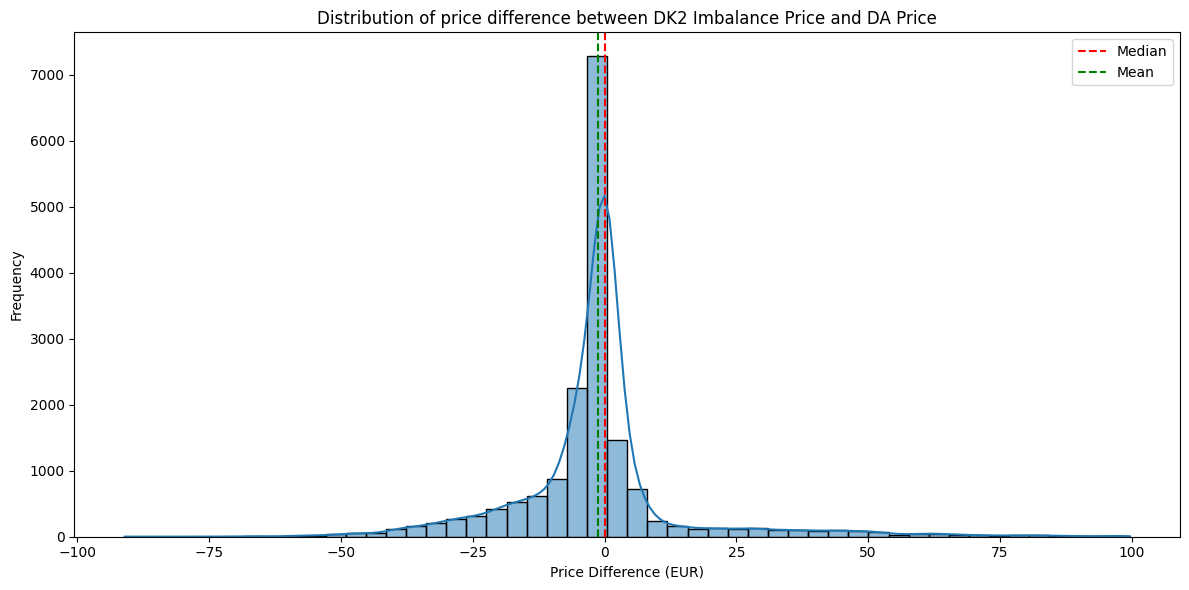

Mean: -1.2853282842994462
Median: 0.0


In [5]:
#filter diff_markets to be between -100 and 100
filtered_data_set = full_data_set[(full_data_set['diff_markets_RE'] > -100) & (full_data_set['diff_markets_RE'] < 100)]

# make a distribution plot of the imbalance price
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data_set['diff_markets_RE'], bins=50, kde=True)
#plot median and mean has vertical line
plt.axvline(filtered_data_set['diff_markets_RE'].median(), color='r', linestyle='--', label='Median')
plt.axvline(filtered_data_set['diff_markets_RE'].mean(), color='g', linestyle='--', label='Mean')
plt.title('Distribution of price difference between DK2 Imbalance Price and DA Price')
plt.xlabel('Price Difference (EUR)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Mean: {filtered_data_set['diff_markets_RE'].mean()}")
print(f"Median: {filtered_data_set['diff_markets_RE'].median()}")

In [6]:
#make a scatter plot or the results
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(title)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

def plot_feature_importance_lr(model, X_train, y_train):
    feature_importance = model.coef_ if hasattr(model, 'coef_') else model.dual_coef_
    feature_names = X_train.columns
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_names)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

def plot_feature_importance_kr(model,  X_train, y_train):
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, scoring='r2')
    importance = result.importances_mean
    feature_names = X_train.columns

    # Sort features by importance
    sorted_idx = importance.argsort()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx])
    plt.title('Permutation Feature Importance')
    plt.xlabel('Mean Importance (R² decrease)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):

    # Fit the model
    model.fit(X_train, y_train)

    #print train statistics
    print(f"Training R^2 Score: {model.score(X_train, y_train)}")
    print(f"Training Mean Squared Error: {mean_squared_error(y_train, model.predict(X_train))}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    # Plot results
    plot_results(y_test, y_pred, f"{model.__class__.__name__} Predictions")
    plot_residuals(y_test, y_pred, f"{model.__class__.__name__} Residuals")
    
    return model

def rolling_window_evaluation(data, model_cls=LinearRegression, train_hours=15*24, test_hours=24):
    results = pd.DataFrame()
    data = data.copy()
    target_col = 'abs_diff_markets_RE'  # Change this to your target column
    y_all = data[target_col]
    delete_cols = ['DK2 Imbalance Price (EUR)', 'DK1 Imbalance Price (EUR)', 'lambda_DA_RE', 'diff_markets_RE', 'abs_diff_markets_RE', 'system_state_RE', 'energy_RE']
    data.drop(columns=delete_cols, inplace=True, errors='ignore')
    X_all= data.copy()
    print(X_all.columns)

    timestamps = data.index

    start = 0
    while start + train_hours + test_hours <= len(data):
        train_start = start
        train_end = start + train_hours
        test_end = train_end + test_hours

        X_train = X_all.iloc[train_start:train_end]
        y_train = y_all.iloc[train_start:train_end]
        X_test = X_all.iloc[train_end:test_end]
        y_test = y_all.iloc[train_end:test_end]

        # Scale
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit model
        model = model_cls()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)


        results = pd.concat([results, pd.DataFrame({
            'datetime_CET': y_test.index,
            'y_true': y_test.values,
            'y_pred': y_pred,
        })], ignore_index=True)
        start += test_hours

    return pd.DataFrame(results)

data = pd.read_csv("../data/processed/full_data_set.csv", index_col=None)
data['datetime_CET'] = pd.to_datetime(data['datetime_CET'], errors='coerce', utc=True)
data.set_index('datetime_CET', inplace=True)
data.dropna(inplace=True)

# Run rolling evaluation with LinearRegression
results_lr = rolling_window_evaluation(data, model_cls=LinearRegression)

# Or with Kernel Ridge
results_kr = rolling_window_evaluation(data, model_cls=lambda: KernelRidge(kernel='rbf', alpha=0.5, gamma=0.1))


Index(['load_FC', 'load_RE', 'Solar_FC', 'Wind_offshore_FC', 'Wind_onshore_FC',
       'DK1 Accepted Down Volume (MW)', 'DK1 Accepted Up Volume (MW)',
       'DK2 Accepted Down Volume (MW)', 'DK2 Accepted Up Volume (MW)',
       'Biomass_RE', 'Fossil_Gas_RE', 'Fossil_Hard_coal_RE', 'Fossil_Oil_RE',
       'Solar_RE', 'Waste_RE', 'Wind_offshore_RE', 'Wind_onshore_RE',
       'lambda_DA_FC', 'energy_FC', 'missing_capacity_RE'],
      dtype='object')
Index(['load_FC', 'load_RE', 'Solar_FC', 'Wind_offshore_FC', 'Wind_onshore_FC',
       'DK1 Accepted Down Volume (MW)', 'DK1 Accepted Up Volume (MW)',
       'DK2 Accepted Down Volume (MW)', 'DK2 Accepted Up Volume (MW)',
       'Biomass_RE', 'Fossil_Gas_RE', 'Fossil_Hard_coal_RE', 'Fossil_Oil_RE',
       'Solar_RE', 'Waste_RE', 'Wind_offshore_RE', 'Wind_onshore_RE',
       'lambda_DA_FC', 'energy_FC', 'missing_capacity_RE'],
      dtype='object')


In [8]:
results_kr['error'] = results_kr['y_true'] - results_kr['y_pred']
results_kr['abs_error'] = results_kr['error'].abs()
results_kr.index = pd.to_datetime(results_kr['datetime_CET'])
results_kr.drop(columns=['datetime_CET'], inplace=True)
results_kr.mean()

y_true       11.509702
y_pred       11.062773
error         0.446929
abs_error    12.496362
dtype: float64

In [9]:
results_lr['error'] = results_lr['y_true'] - results_lr['y_pred']
results_lr['abs_error'] = results_lr['error'].abs()
results_lr.index = pd.to_datetime(results_lr['datetime_CET'])
results_lr.drop(columns=['datetime_CET'], inplace=True)
results_lr.mean()

y_true       11.509702
y_pred       12.369295
error        -0.859594
abs_error    15.750050
dtype: float64

In [10]:
r2_kr = r2_score(results_kr['y_true'], results_kr['y_pred'])
print(f"Kernel R^2 Score: {r2_kr}")
r2_lr = r2_score(results_lr['y_true'], results_lr['y_pred'])
print(f"Linear R^2 Score: {r2_lr}")



Kernel R^2 Score: 0.08751824586185664
Linear R^2 Score: -1.0290631439679863
